<a href="https://colab.research.google.com/github/theharshithh/dl-notebook/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate optical flow from an image

In [18]:
!wget "https://u2uj4w.dm.files.1drv.com/y4m2_2zlpiRNgOyeCap0CQojBBXRO4O7j7QCsj15Ulg3CIYKgFmka6SB1_ZEKk2DKJpYplyILjavncdzEH5QQNysPpEdkGgTQaIoJwd5nWPtSYudKwd8puPdewNfm1uNCj2zxSSBMtlMLw_tod5XumDfmM_Nf9dGli_Lz9INd78_RlSxtRP17gBT1wwRmd-Udv-PR3ShuzlMbH8EdWIjro2Dg" -O models2.zip


--2025-02-17 16:59:16--  https://u2uj4w.dm.files.1drv.com/y4m2_2zlpiRNgOyeCap0CQojBBXRO4O7j7QCsj15Ulg3CIYKgFmka6SB1_ZEKk2DKJpYplyILjavncdzEH5QQNysPpEdkGgTQaIoJwd5nWPtSYudKwd8puPdewNfm1uNCj2zxSSBMtlMLw_tod5XumDfmM_Nf9dGli_Lz9INd78_RlSxtRP17gBT1wwRmd-Udv-PR3ShuzlMbH8EdWIjro2Dg
Resolving u2uj4w.dm.files.1drv.com (u2uj4w.dm.files.1drv.com)... 13.107.42.12
Connecting to u2uj4w.dm.files.1drv.com (u2uj4w.dm.files.1drv.com)|13.107.42.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1055177141 (1006M) [application/zip]
Saving to: ‘models2.zip’

models2.zip         100%[===================>]   1006M  18.6MB/s    in 54s     

2025-02-17 17:00:11 (18.6 MB/s) - ‘models2.zip’ saved [1055177141/1055177141]



In [ ]:
!git clone https://github.com/fltwr/generative-image-dynamics.git

In [27]:
%cd /content/generative-image-dynamics

/content/generative-image-dynamics


In [28]:
!pwd

/content/generative-image-dynamics


In [29]:
!unzip data/model.zip

Archive:  data/model.zip
  inflating: models/frame_synthesis.pth  
   creating: models/unet/
  inflating: models/unet/config.json  
  inflating: models/unet/diffusion_pytorch_model.safetensors  


In [6]:
%cd generative-image-dynamics

/content/generative-image-dynamics


In [7]:
import os
print(os.path.exists("data/models/unet/"))


True


In [8]:
import os
import datetime
import torch
from diffusers import UNet2DModel, DDPMScheduler
from models.motion_synthesis import VQModel_, generate_spectrum
from utils import *

if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

transforms = FrameSpectrumProcessing(num_freq=16)
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.0015, beta_end=0.0195, beta_schedule="scaled_linear")
vae = VQModel_.from_pretrained("CompVis/ldm-celebahq-256", subfolder="vqvae", allow_pickle=False).to(DEVICE).eval()
unet = UNet2DModel.from_pretrained("data/models/unet").to(DEVICE).eval()

out_dir = "data/unet_samples"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(

An error occurred while trying to fetch CompVis/ldm-celebahq-256: CompVis/ldm-celebahq-256 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [9]:
# Load an image
image_path = "data/images/512px-001_2015_04_19_Das_Gelb_der_Natur.jpg"
frame_np = get_image(image_path, width=256, height=160, crop=True)
frame = transforms.process_frame(frame_np).unsqueeze(0).to(DEVICE)

# Generate motion spectrum
num_steps = 100

sample_name = "_".join([
    os.path.split(image_path)[1],
    "ddpm" + str(num_steps),
    datetime.datetime.now().isoformat().replace(":", "_")
])

spec_np = generate_spectrum(vae, unet, noise_scheduler, frame, num_steps=num_steps, batch_size=1)

path = os.path.join(out_dir, sample_name + ".npy")
save_npy(spec_np, path)
print(f"sample saved at {path}")

# Visualize the result
spec_image, video = visualize_sample(frame_np, spec_np, transforms, magnification=5.0, include_flow=True)

path = os.path.join(out_dir, sample_name + ".png")
spec_image.save(path)
print(f"spectrum image saved at {path}")

path = os.path.join(out_dir, sample_name + ".mp4")
video.write_videofile(path, logger=None)
print(f"video saved at {path}")

  0%|          | 0/16 [00:00<?, ?it/s]WARNING:py.warnings:/content/generative-image-dynamics/models/motion_synthesis.py:60: FutureWarning: Accessing config attribute `out_channels` directly via 'UNet2DModel' object attribute is deprecated. Please access 'out_channels' over 'UNet2DModel's config object instead, e.g. 'unet.config.out_channels'.
  sample = torch.randn(bs, unet.out_channels, *frame.shape[2:], dtype=frame.dtype, device=frame.device)

100%|██████████| 16/16 [01:41<00:00,  6.32s/it]


sample saved at data/unet_samples/512px-001_2015_04_19_Das_Gelb_der_Natur.jpg_ddpm100_2025-02-17T17_28_25.400898.npy
spectrum image saved at data/unet_samples/512px-001_2015_04_19_Das_Gelb_der_Natur.jpg_ddpm100_2025-02-17T17_28_25.400898.png
video saved at data/unet_samples/512px-001_2015_04_19_Das_Gelb_der_Natur.jpg_ddpm100_2025-02-17T17_28_25.400898.mp4


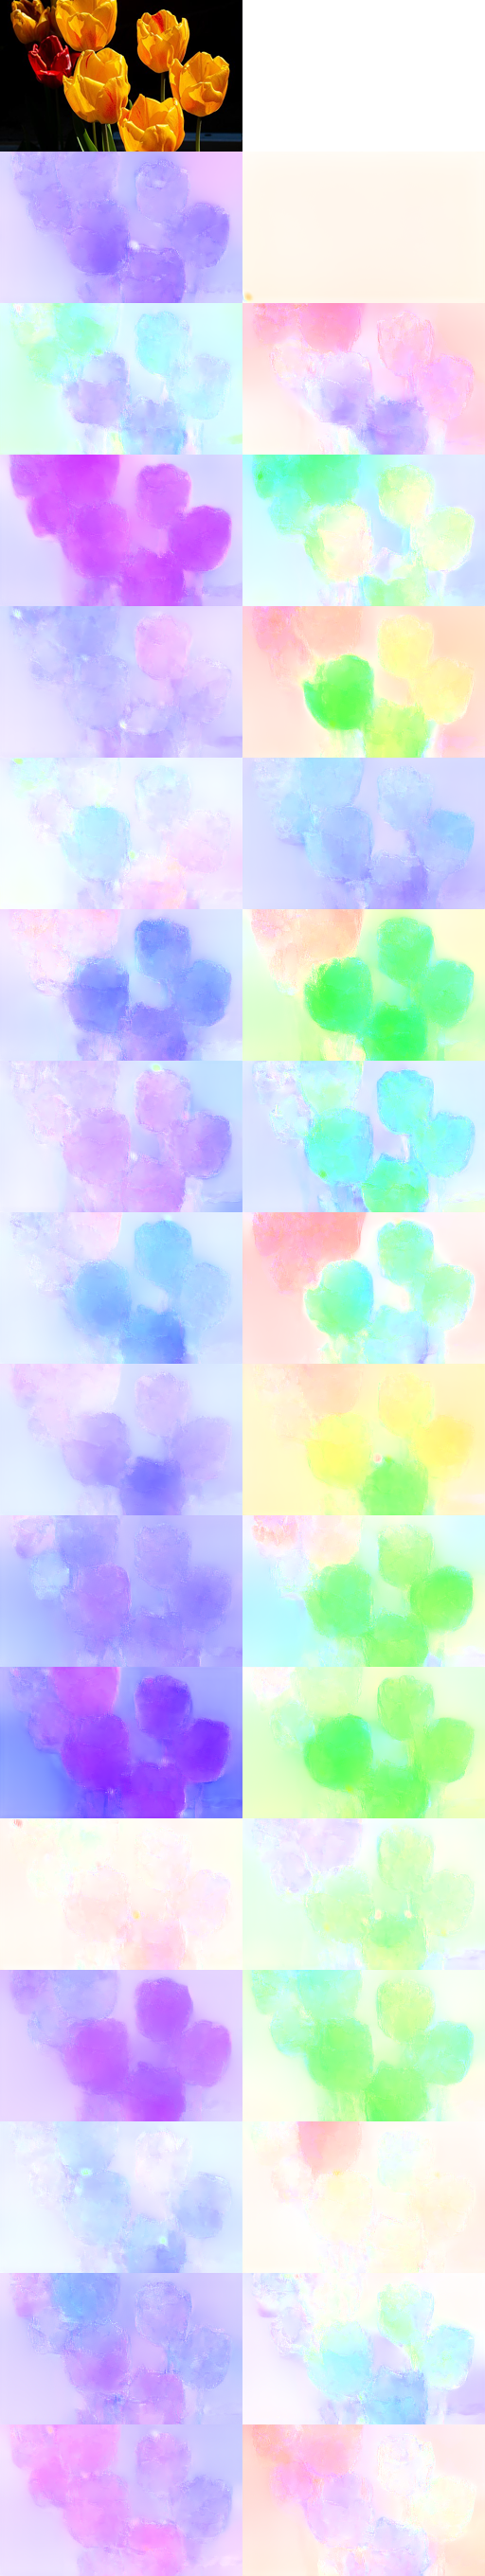

In [10]:
# Show generated FFT in an image. Each row shows a frequency with the real part on the left and the imaginary part on the right.
spec_image

In [11]:
# Show optical flow derived from generated spectrum and warped frames
video.ipython_display(loop=1, autoplay=1, rd_kwargs=dict(logger=None))

# Generate video from image and optical flow

In [12]:
# !git clone https://github.com/pathak22/pyflow.git


In [13]:
# !python setup.py build_ext -i

In [14]:
# %cd ..

In [15]:
import datetime
import moviepy.editor as mpy
from models.frame_synthesis import *
from utils import *
from utils.flow import optical_flow
DEVICE = torch.device("cuda:0")

model = Synthesis()
model.load_state_dict(torch.load("data/models/frame_synthesis.pth")["model"])
model = model.to(DEVICE).eval()

transforms = FrameFlowProcessing()

  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)

  @torch.cuda.amp.custom_bwd

  model.load_state_dict(torch.load("data/models/frame_synthesis.pth")["model"])



In [16]:
# Load a 5-second frame sequence
video_path = "data/videos/Fleur_de_pommier_18.mp4"
start_sec = 5
fps = 30
num_frames = 150

frames = get_frames(video_path, w=256, h=160, start_sec=start_sec, fps=fps, f=num_frames)

# Show the sequence
clip = mpy.ImageSequenceClip(list(frames), fps=fps)
clip.ipython_display(loop=1, autoplay=1, rd_kwargs=dict(logger=None))

In [61]:
!pip install ./pyflow

Processing ./pyflow
  Preparing metadata (setup.py) ... done
  Created wheel for pyflow: filename=pyflow-1.0-cp311-cp311-linux_x86_64.whl size=388736 sha256=fa1236d54d274af778de0cf965345118a0ace5b01c8f5a680b4357e6d5324d74
  Stored in directory: /tmp/pip-ephem-wheel-cache-g00ygkqj/wheels/75/b1/e6/e44d3cf82ebcb4fc8624e617219954eca32ed663ac8f963129
Successfully built pyflow
  Attempting uninstall: pyflow
    Found existing installation: pyflow 0.3.1
    Uninstalling pyflow-0.3.1:
      Successfully uninstalled pyflow-0.3.1


In [17]:
# Estimate optical flow from the first frame to each frame
start_time = datetime.datetime.now()
flow = optical_flow(frames[0], frames[1:])
print(datetime.datetime.now() - start_time)

0:02:07.935989


In [18]:
# Visualize optical flow
flow_color = flow_to_color_video(flow)

clip = mpy.ImageSequenceClip(list(flow_color), fps=30)
clip.ipython_display(loop=1, autoplay=1, rd_kwargs=dict(logger=None))

In [23]:
# Reconstruct the video from the first frame and optical flow
src_frame = transforms.process_frame(frames[0]).unsqueeze(0).to(DEVICE)
print(src_frame.shape)
flow_np = flow.cpu().numpy()
flow = transforms.process_flow(flow_np).to(DEVICE)
pred = predict_tensor(src_frame, flow, model, transforms, return_tensor=False)

clip = mpy.ImageSequenceClip(list(np.concatenate([
    add_video_title(frames[1:], "Original frames"),
    add_video_title(pred, "Model prediction")
], axis=2)), fps=30)
clip.ipython_display(loop=1, autoplay=1, rd_kwargs=dict(logger=None))

torch.Size([1, 3, 160, 256])


RuntimeError: Given groups=1, weight of size [8, 2, 3, 3], expected input[32, 256, 2, 160] to have 2 channels, but got 256 channels instead